In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
# import folium as folium
# from os import path
# from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# from matplotlib_venn import venn3, venn3_circles

# TP1

In [6]:
df_original = pd.read_csv("train.csv", dtype={
    'tipodepropiedad':'category', 'ciudad':'category',\
    'provincia':'category', 'gimnasio':'bool', 'usosmultiples':'bool',\
    'piscina':'bool', 'escuelascercanas':'bool',\
    'centroscomercialescercanos':'bool' }, parse_dates=[16])

In [7]:
# Renombramos convenientemente algunas columnas
df_original = df_original.rename(columns={'tipodepropiedad':'tipo', 'habitaciones':'cant_habitaciones', 'garages':'cant_garages', 'banos':'cant_banios',
       'lat':'latitud', 'lng':'longitud'})

In [8]:
df_original.columns

Index(['id', 'titulo', 'descripcion', 'tipo', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'cant_habitaciones', 'cant_garages',
       'cant_banios', 'metroscubiertos', 'metrostotales', 'idzona', 'latitud',
       'longitud', 'fecha', 'gimnasio', 'usosmultiples', 'piscina',
       'escuelascercanas', 'centroscomercialescercanos', 'precio'],
      dtype='object')

In [9]:
# Identificamos para cada columna qué porcentaje de los datos de cada columna son nulos 

porcentajes = df_original.isna().sum()/len(df_original.index)

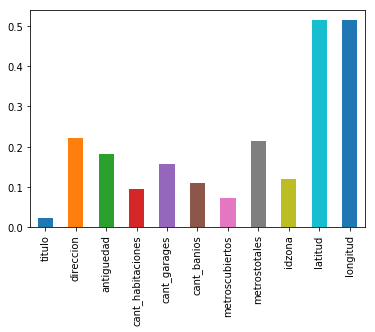

In [10]:
porcentajes_mayores_1 = porcentajes[porcentajes >= 0.01]
porcentajes_mayores_1.plot(kind='bar')

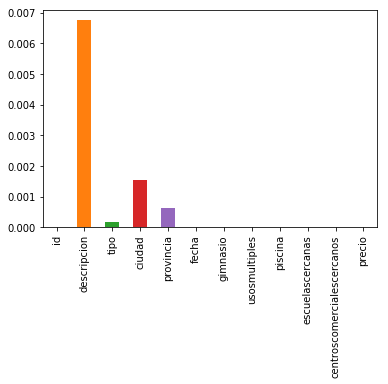

In [11]:
porcentajes_menores_1 = porcentajes[porcentajes < 0.01]
porcentajes_menores_1.plot(kind='bar')

In [12]:
df_original['anio'] = df_original['fecha'].dt.year

In [13]:
df_original['mes'] = df_original['fecha'].dt.month

In [14]:
df_original.anio

0         2015
1         2013
2         2015
3         2012
4         2016
5         2014
6         2016
7         2016
8         2014
9         2016
10        2013
11        2014
12        2013
13        2015
14        2014
15        2015
16        2013
17        2016
18        2016
19        2016
20        2013
21        2016
22        2013
23        2015
24        2013
25        2016
26        2014
27        2012
28        2015
29        2016
          ... 
239970    2016
239971    2016
239972    2016
239973    2013
239974    2015
239975    2014
239976    2015
239977    2015
239978    2016
239979    2016
239980    2016
239981    2012
239982    2016
239983    2016
239984    2016
239985    2016
239986    2013
239987    2015
239988    2015
239989    2016
239990    2014
239991    2015
239992    2015
239993    2015
239994    2013
239995    2015
239996    2014
239997    2015
239998    2014
239999    2015
Name: anio, Length: 240000, dtype: int64

In [15]:
df_original.mes

0          8
1          6
2         10
3          3
4          6
5          3
6          2
7         10
8          1
9         12
10         1
11        12
12         8
13         3
14        11
15         1
16         3
17        10
18        12
19         1
20        12
21         2
22        12
23         5
24         9
25        12
26         7
27         3
28         1
29        12
          ..
239970    12
239971    12
239972     1
239973     2
239974     8
239975     4
239976     2
239977     4
239978    10
239979     3
239980    12
239981    11
239982     2
239983     2
239984     7
239985    12
239986     9
239987    10
239988    11
239989     9
239990     4
239991     3
239992    11
239993     3
239994     7
239995     2
239996     7
239997     3
239998    12
239999     6
Name: mes, Length: 240000, dtype: int64

Comparar el siguiente gráfico con la inflación en Mexico
[https://www.focus-economics.com/country-indicator/mexico/inflation]
[https://www.inflation.eu/inflation-rates/mexico/historic-inflation/cpi-inflation-mexico.aspx]
[https://www.globalpropertyguide.com/Latin-America/mexico/Price-History]

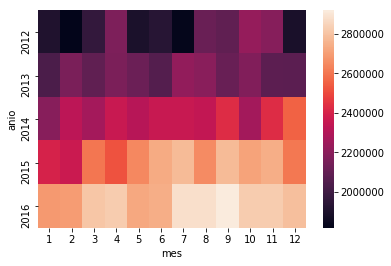

In [16]:
mes_x_anio = df_original.pivot_table(index='anio', columns='mes', values='precio', aggfunc='mean')
g = sns.heatmap(mes_x_anio)

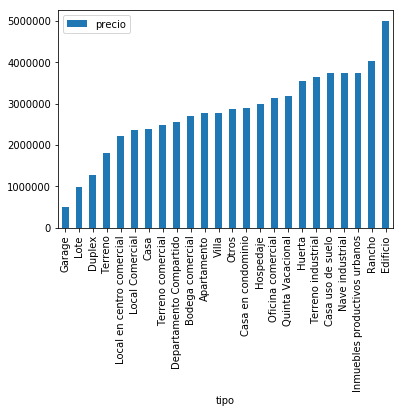

In [17]:
# Precio promedio por tipo
df_original.groupby('tipo').agg({'precio':'mean'}).sort_values('precio').plot(kind='bar')

/usr/lib/python3/dist-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


Text(0.5,1,'Cantidad total de propiedades')

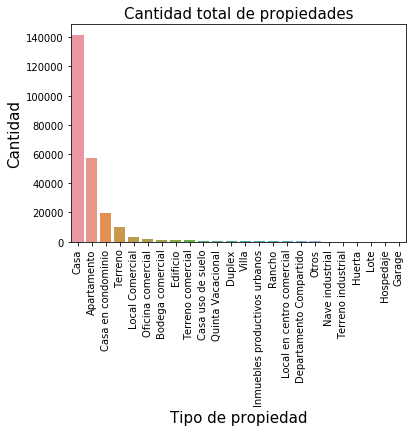

In [18]:
g = sns.countplot(x='tipo', data=df_original, order=df_original['tipo'].value_counts().index, orient='v')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_xlabel("Tipo de propiedad", fontsize=15)
g.set_ylabel("Cantidad", fontsize=15)
g.set_title("Cantidad total de propiedades", fontsize=15)

# Filtracion

In [19]:
## funcion para setear los superficies
def set_metros(row):
    total = row.metrostotales
    covered = row.metroscubiertos
    if np.isnan(total):
        row.metrostotales = covered
        return row
    if np.isnan(covered):
        row.metroscubiertos = total
        return row
    return row

In [20]:
df_filtrado_metro = df_original.copy()
df_filtrado_metro = df_filtrado_metro.apply(set_metros, axis = 1)

In [21]:
# chequeo las infos antes de filtrar
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 25 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipo                          239954 non-null category
direccion                     186928 non-null object
ciudad                        239628 non-null category
provincia                     239845 non-null category
antiguedad                    196445 non-null float64
cant_habitaciones             217529 non-null float64
cant_garages                  202235 non-null float64
cant_banios                   213779 non-null float64
metroscubiertos               222600 non-null float64
metrostotales                 188533 non-null float64
idzona                        211379 non-null float64
latitud                       116512 non-null float64
longitud                      116512 non-null float64
fecha                      

In [22]:
## informacion despues de filtrar
df_filtrado_metro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 25 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipo                          239954 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
cant_habitaciones             217529 non-null float64
cant_garages                  202235 non-null float64
cant_banios                   213779 non-null float64
metroscubiertos               240000 non-null float64
metrostotales                 240000 non-null float64
idzona                        211379 non-null float64
latitud                       116512 non-null float64
longitud                      116512 non-null float64
fecha                         240

In [23]:
# verificando los percentajes de cada tipo
df_filtrado_metro['tipo'].value_counts(normalize = 1)

Casa                             0.590601
Apartamento                      0.238967
Casa en condominio               0.080420
Terreno                          0.041445
Local Comercial                  0.012732
Oficina comercial                0.007256
Bodega comercial                 0.005859
Edificio                         0.005818
Terreno comercial                0.005526
Casa uso de suelo                0.002951
Quinta Vacacional                0.001646
Duplex                           0.001429
Villa                            0.001417
Inmuebles productivos urbanos    0.000833
Rancho                           0.000708
Local en centro comercial        0.000688
Departamento Compartido          0.000588
Otros                            0.000558
Nave industrial                  0.000317
Terreno industrial               0.000129
Huerta                           0.000083
Lote                             0.000021
Garage                           0.000004
Hospedaje                        0

Se puede observar que a partir de Local Comercial, tiene un percentaje menor que 2%, por lo tanto decidimos que agrupar las propiedades que tienen un porcentaje menor que 2% a tipo 'otro'

In [24]:
# funcion para setear los tipos
def set_tipo(row):
    tipo = row.tipo
    if tipo == 'Casa' or tipo == 'Apartamento' \
    or tipo == 'Casa en condominio' or tipo == 'Terreno':
        return row
    else:
        row.tipo = 'Otros'
        return row
    return row

In [25]:
df_filtrado_tipo = df_filtrado_metro.copy()
df_filtrado_tipo = df_filtrado_tipo.apply(set_tipo, axis = 1)

In [26]:
# verificando los datos despues de filtrar y percentajes de los tipos
df_filtrado_tipo.info()
df_filtrado_tipo['tipo'].value_counts(normalize = 1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 25 columns):
id                            240000 non-null int64
titulo                        234613 non-null object
descripcion                   238381 non-null object
tipo                          240000 non-null object
direccion                     186928 non-null object
ciudad                        239628 non-null object
provincia                     239845 non-null object
antiguedad                    196445 non-null float64
cant_habitaciones             217529 non-null float64
cant_garages                  202235 non-null float64
cant_banios                   213779 non-null float64
metroscubiertos               240000 non-null float64
metrostotales                 240000 non-null float64
idzona                        211379 non-null float64
latitud                       116512 non-null float64
longitud                      116512 non-null float64
fecha                         240

Casa                  0.590488
Apartamento           0.238921
Casa en condominio    0.080404
Otros                 0.048750
Terreno               0.041438
Name: tipo, dtype: float64

agregando una columna de precio por metros en dollar y genera una nueva data_set con solo'tipo','metrostotales','precio por metros'

In [27]:
df_filtrado_tipo['precio por metros'] = df_filtrado_tipo.precio/df_filtrado_tipo.metrostotales/50
df_filtrado = df_filtrado_tipo.copy()
df_tipo_precio = df_filtrado_tipo[['tipo','precio por metros']]
df_tipo_precio.info()

df_filtrado['precioporm2'] = df_filtrado['precio'] / df_filtrado['metrostotales']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240000 entries, 0 to 239999
Data columns (total 2 columns):
tipo                 240000 non-null object
precio por metros    240000 non-null float64
dtypes: float64(1), object(1)
memory usage: 3.7+ MB


## los datos filtrados ahora se llama df_filtrado

# Analizando los tipos de propiedades

In [ ]:
# un grafico de presentar percentajes de cada tipo
df_tipo = df_tipo_precio['tipo'].value_counts().to_frame()
df_tipo.plot(kind='pie', subplots=True, figsize=(8, 8), autopct='%1.0f%%',title='Distribucion de tipo')

In [ ]:
#analiza promedio de precio por medio de cada tipo
df_tipo_precio.groupby('tipo').agg({'precio por metros':'mean'}).sort_values('precio por metros').plot(kind='bar', title = 'Promedio de precio por metro de cada tipo')

Analizando promedio de precio por metro en cada provincia segun el tipo

In [ ]:
#filtrando uno con precio tipo y provincia (falta elegir un mejor grafico)
df_tipo_provincia = df_filtrado [['provincia','precio por metros','tipo']]
df_tp = df_tipo_provincia.groupby(['tipo','provincia']).agg({'precio por metros' :'mean'})
df_tp = df_tp.reset_index()

In [ ]:
g= sns.stripplot(x='provincia', y='precio por metros', hue= 'tipo', data=df_tp, order=None, 
                      hue_order=None, jitter=True, 
                      split=False, orient=None, 
                      color=None, palette=None, size=5, 
                      edgecolor="gray", linewidth=0, 
                      ax=None)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

# Analizando los factores de escuelas y centroscomerciales

In [ ]:
#filtrando dato solo con tipo precio y escuelas cercanas
df_escuela = df_filtrado [['tipo','precio por metros', 'escuelascercanas']]
df_escuela.head()

In [ ]:
# comparando precio pormedio directamente con el factor de escuela
df_ec_precio = df_escuela.groupby('escuelascercanas').agg({'precio por metros' :'mean'})
g = df_ec_precio.plot(kind='bar', fontsize = 10)
g.set_title("Diferencia de precio por medio  con factor escuela", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Precio promedio", fontsize=18)
g.set_xticklabels(g.get_xticklabels(),rotation=0)

In [ ]:
# filtrar el factor escuelas con diferentes tipos
df_ec_tipo = df_escuela.groupby(['tipo','escuelascercanas']).agg({'precio por metros' :'mean'})
df_ec = df_ec_tipo.pivot_table(index="tipo", \
                                 columns="escuelascercanas", \
                                 values="precio por metros", fill_value=0)
df_ec = df_ec.reset_index()
df_ec.set_index('tipo', inplace=True) 
df_ec

In [ ]:
# representa en grafico
g = df_ec.plot(kind='bar', fontsize = 10)
g.set_title("Diferencia de precio con factor escuela", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Precio promedio", fontsize=18)

In [ ]:
# filtrar dato con 3 columnas tipo, precio por medio y centroscomerciales
df_centrocomercial = df_filtrado [['tipo','precio por metros', 'centroscomercialescercanos']]
df_centrocomercial.head()

In [ ]:
#comparando el factor de centro con el promedio de precio
df_cc_precio = df_centrocomercial.groupby('centroscomercialescercanos').agg({'precio por metros' :'mean'})
g = df_cc_precio.plot(kind='bar', fontsize = 10)
g.set_title("Diferencia de precio por medio  con factor centro comercial", fontsize=18)
g.set_xlabel("Tipo de propiedad", fontsize=18)
g.set_ylabel("Precio promedio", fontsize=18)
g.set_xticklabels(g.get_xticklabels(),rotation=0)

In [ ]:
#filtrar el dato de diferentes tipos con el promedio de pr

## **Analisis segun antiguedad**

In [ ]:
df_filtrado['tipo'].value_counts()

In [ ]:
#Me quedo con aquellas publicaciones que tengan valores consistentes.

df_filtrado_antiguedad = df_filtrado.loc[df_filtrado['metrostotales'] > 0]
df_filtrado_antiguedad = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['metroscubiertos'] > 0]

#Me quedo con tipos: Casa, Apartamento y Casa en condominio

df_filtrado_antiguedad = df_filtrado_antiguedad.loc[(df_filtrado_antiguedad['tipo'] != 'Otros') | (df_filtrado_antiguedad['tipo'] != 'Terreno')]

In [ ]:
#Filtro las publicaciones que no tienen antiguedad ni precio

df_filtrado_antiguedad = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['antiguedad']>=0]
df_filtrado_antiguedad = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['precio']>0]

#Calculo precio por m2

df_filtrado_antiguedad['precioporm2'] = df_filtrado_antiguedad['precio'] / df_filtrado_antiguedad['metrostotales']

In [ ]:
#Calculo el promedio de precioporm2 segun la antiguedad por tipo (Casa, Apartamento, Casa en condominio)

df_filtered_casa = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['tipo'] == 'Casa']
preciom2_segun_antiguedad_casa = df_filtered_casa.groupby('antiguedad').agg({'precioporm2' : 'mean', 'id' : 'count'})
preciom2_segun_antiguedad_casa.reset_index(inplace = True)
preciom2_segun_antiguedad_casa.columns = ['antiguedad', 'precioporm2', 'cantidaddepublicaciones']

df_filtered_apartamento = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['tipo'] == 'Apartamento']
preciom2_segun_antiguedad_apartamento = df_filtered_apartamento.groupby('antiguedad').agg({'precioporm2' : 'mean', 'id' : 'count'})
preciom2_segun_antiguedad_apartamento.reset_index(inplace = True)
preciom2_segun_antiguedad_apartamento.columns = ['antiguedad', 'precioporm2', 'cantidaddepublicaciones']

df_filtered_casa_condo = df_filtrado_antiguedad.loc[df_filtrado_antiguedad['tipo'] == 'Casa en condominio']
preciom2_segun_antiguedad_casa_condo = df_filtered_casa_condo.groupby('antiguedad').agg({'precioporm2' : 'mean', 'id' : 'count'})
preciom2_segun_antiguedad_casa_condo.reset_index(inplace = True)
preciom2_segun_antiguedad_casa_condo.columns = ['antiguedad', 'precioporm2', 'cantidaddepublicaciones']

In [ ]:
#Filtro aquellos anios de antiguedad que tengan muy pocas publciaciones, asi se toman valores muestrales representativos.

cantidad_promedio_casa = preciom2_segun_antiguedad_casa['cantidaddepublicaciones'].mean()
preciom2_segun_antiguedad_casa = preciom2_segun_antiguedad_casa.loc[preciom2_segun_antiguedad_casa['cantidaddepublicaciones'] >= 0.05*cantidad_promedio_casa]

cantidad_promedio_apartamento = preciom2_segun_antiguedad_apartamento['cantidaddepublicaciones'].mean()
preciom2_segun_antiguedad_apartamento = preciom2_segun_antiguedad_apartamento\
                            .loc[preciom2_segun_antiguedad_apartamento['cantidaddepublicaciones'] >= 0.05*cantidad_promedio_apartamento]

cantidad_promedio_casa_condo = preciom2_segun_antiguedad_casa_condo['cantidaddepublicaciones'].mean()
preciom2_segun_antiguedad_casa_condo = preciom2_segun_antiguedad_casa_condo\
                            .loc[preciom2_segun_antiguedad_casa_condo['cantidaddepublicaciones'] >= 0.1*cantidad_promedio_casa_condo]

In [ ]:
#Precio del metro cuadrado en Casas / Apartamentos / Casas en Condominio vs Antiguedad
sns.regplot(x=preciom2_segun_antiguedad_casa["antiguedad"], y=preciom2_segun_antiguedad_casa["precioporm2"], fit_reg = False, color = 'black')\
                            .set_title("Precio del m2 vs Antiguedad en Casas")

In [ ]:
sns.regplot(x=preciom2_segun_antiguedad_apartamento["antiguedad"], y=preciom2_segun_antiguedad_apartamento["precioporm2"], fit_reg = False, color = 'orange')\
                            .set_title("Precio del m2 vs Antiguedad en Apartamentos")

In [ ]:
sns.regplot(x=preciom2_segun_antiguedad_casa_condo["antiguedad"], y=preciom2_segun_antiguedad_casa_condo["precioporm2"], fit_reg = False, color = 'olive')\
                            .set_title("Precio del m2 vs Antiguedad en Casa en condominio")

## **Analisis segun cantidad de banios, habitaciones, garages**

In [ ]:
#Analisis de cantidad de banios y habitaciones

#Sera efectuado unicamente sobre Casas, Apartamentos y Casa en condominio
df_filtrado_cantidades = df_filtrado.loc[(df_filtrado['tipo'] != 'Otros') | (df_filtrado['tipo'] != 'Terreno')]

#Me quedo con aquellos que tengan al menos una habitacion
df_filtrado_cantidades = df_filtrado_cantidades.loc[df_filtrado_cantidades['cant_habitaciones'] > 0]

In [ ]:
habitaciones_grouped = df_filtrado_cantidades.groupby('cant_habitaciones').agg({'id' : 'count'})
habitaciones_grouped.columns = ['cantidad_propiedades']
habitaciones_grouped.reset_index(inplace = True)
habitaciones_grouped['cant_habitaciones'] = habitaciones_grouped['cant_habitaciones'].apply(lambda x: x if x < 6 else "6+")
habitaciones_grouped = habitaciones_grouped.groupby('cant_habitaciones').agg({'cantidad_propiedades':'sum'})
habitaciones_grouped


In [ ]:
habitaciones_grouped.plot(kind='pie', figsize=(5,5),cmap='Accent',fontsize=11, y = 'cantidad_propiedades')
plt.title('Cantidad de habitaciones', fontsize = 18)
plt.ylabel('')
plt.show();

In [ ]:
#Precio vs cantidad de habitaciones
precio_por_habitaciones = df_filtrado_cantidades.groupby('cant_habitaciones').agg({'precio' : 'mean'})
precio_por_habitaciones.reset_index(inplace = True)
precio_por_habitaciones.columns = ['cantidad_de_habitaciones', 'precio_promedio']

In [ ]:
sns.regplot(x=precio_por_habitaciones["cantidad_de_habitaciones"], y=precio_por_habitaciones["precio_promedio"], color = 'blue')\
                .set_title("Precio promedio vs cantidad de habitaciones")

In [ ]:
#Precio promedio vs cantidad de banos

#Filtro aquellos que no tengan banos
df_filtrado_cantidades = df_filtrado_cantidades.loc[df_filtrado_cantidades['cant_banios'] > 0]

In [ ]:
banios_grouped = df_filtrado_cantidades.groupby('cant_banios').size().plot(kind='pie', figsize=(5,5),cmap='Accent',fontsize=11)
plt.title('Cantidad de banios', fontsize = 18)
plt.ylabel('')
plt.show();

In [ ]:
#Agrupo por cantidad de banos y calculo precio promedio
precio_por_banos = df_filtrado_cantidades.groupby('cant_banios').agg({'precio' : 'mean'})
precio_por_banos.reset_index(inplace = True)
precio_por_banos.columns = ['cantidad_de_banos', 'precio_promedio']

sns.regplot(x=precio_por_banos["cantidad_de_banos"], y=precio_por_banos["precio_promedio"], color = 'olive')\
                .set_title("Precio promedio vs cantidad de banos")

In [ ]:
#Precio promedio vs cantidad de garages

#Filtro aquellos que no tengan garages
df_filtrado_cantidades = df_filtrado_cantidades.loc[df_filtrado_cantidades['cant_garages'] > 0]

In [ ]:
banios_grouped = df_filtrado_cantidades.groupby('cant_garages').size().plot(kind='pie', figsize=(5,5),cmap='Accent',fontsize=11)
plt.title('Cantidad de garages', fontsize = 18)
plt.ylabel('')
plt.show();

In [ ]:
#Agrupo por cantidad de garages y calculo precio promedio
precio_por_garages = df_filtrado_cantidades.groupby('cant_garages').agg({'precio' : 'mean'})
precio_por_garages.reset_index(inplace = True)
precio_por_garages.columns = ['cantidad_de_garages', 'precio_promedio']

sns.regplot(x=precio_por_garages["cantidad_de_garages"], y=precio_por_garages["precio_promedio"], color = 'black')\
                .set_title("Precio promedio vs cantidad de garages")

In [ ]:
#Analizo en conjunto el precio vs cantidad_de_habitaciones, cantidad_de_banios, cantidad_de_garages

#Quito las publicaciones con mas de cuatro habitaciones asi ajusta la interseccion de las 3 categorias. La tendencia, de todas formas, ya se analizo por separado

precio_por_habitaciones = precio_por_habitaciones.drop([x for x in range(4, 10)])

plt.plot( 'cantidad_de_habitaciones', 'precio_promedio', data=precio_por_habitaciones, marker='', markerfacecolor='blue', color='blue', linewidth=4, label = "habitaciones")
plt.plot( 'cantidad_de_banos', 'precio_promedio', data=precio_por_banos, marker='', color='olive', linewidth=4, label = "banios")
plt.plot( 'cantidad_de_garages', 'precio_promedio', data=precio_por_garages, marker='', color='black', linewidth=4, label="garages")
plt.legend()

## **Análisis de las descripciones**

In [ ]:
#Filtro aquellas publicaciones que no tengan descripciones
df_filtrado_descripciones = df_filtrado.loc[~df_filtrado.descripcion.isnull()]

In [ ]:
def filtrar_descripciones(descripcion):
    descripcion = descripcion.replace("\n", "")
    descripcion = descripcion.replace("<p>", "")
    descripcion = descripcion.replace("<\p>", "")
    descripcion = descripcion.replace("nbsp", "")
    descripcion = descripcion.replace("ntilde", "")
    descripcion = descripcion.replace("ntil", "")
    descripcion = descripcion.replace("strong","")
    palabras = descripcion.split()
    for palabra in palabras:
        if len(palabra) <= 3:
            palabras.remove(palabra)
    descripcion_final = " ".join(palabras)
    return descripcion_final

df_filtrado_descripciones['descripcion'] = df_filtrado_descripciones['descripcion'].apply(filtrar_descripciones)

In [ ]:
descripciones = " ".join(descripcion for descripcion in df_filtrado_descripciones.descripcion)
print ("Hay {} palabras en total que conforman todas las descripciones".format(len(descripciones)))

In [ ]:
#Ajusto el WordCloud a la forma de una casa
mascara_casa = np.array(Image.open("files/casa.png"))
mascara_casa

In [ ]:
def transformar_formato(valor):
    if valor == 0:
        return 255
    else:
        return valor

mascara_casa_transformada = np.ndarray((mascara_casa.shape[0],mascara_casa.shape[1]), np.int32)
for i in range(len(mascara_casa)):
    mascara_casa_transformada[i] = list(map(transformar_formato, mascara_casa[i]))
    
mascara_casa_transformada

In [ ]:
# Creo la imagen del WordCloud
wc = WordCloud(background_color="white", max_words=1000, mask=mascara_casa_transformada, contour_width=3, contour_color='black')

# Genero a partir de las palabras de las descripciones
wc.generate(descripciones)

# Lo guardo en un archivo
wc.to_file("files/wordcloud_casa.png")

# Mostrar
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## **Análisis por provincia**

### **Cantidad de publicaciones por provincia**

In [ ]:
state_geo = 'files/mexican_states.json'

In [ ]:
#Veo cuantas publicaciones hay por estado

#Primero, filtro aquellos que no tengan info del estado:
df_filtrado_provincias = df_filtrado.loc[~df_filtrado['provincia'].isnull()]

In [ ]:
#Reemplazo los nombres por los del GeoJSON
df_filtrado_provincias['provincia'] = df_filtrado_provincias['provincia'].replace({'Edo. de México' : 'Mexico',
                                               'Querétaro' : 'Queretaro',
                                               'Nuevo León' : 'Nuevo Leon',
                                               'San luis Potosí' : 'San Luis Potosi',
                                               'Yucatán' : 'Yucatan',
                                               'Baja California Norte' : 'Baja California',
                                               'Michoacán' : 'Michoacan'})

In [ ]:
#Sumo la cantidad de publicaciones por provincia
cantidad_por_provincia = df_filtrado_provincias.groupby('provincia').agg({'id' : 'count'})
cantidad_por_provincia.reset_index(inplace = True)
cantidad_por_provincia.columns = ['provincia', 'cantidad_de_publicaciones']

In [ ]:
#Inicializo mapa con folium
mapa = folium.Map(location=[21, -101], zoom_start=5)
#mapa

In [ ]:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=cantidad_por_provincia,
    columns=['provincia', 'cantidad_de_publicaciones'],
    key_on='properties.admin_name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Cantidad de publicaciones por Provincia'
).add_to(mapa)

folium.LayerControl().add_to(mapa)

mapa

## **Provincias más caras** (precio por m2 promedio por provincia)

In [ ]:
#Analizo el precio por m2 promedio por provincia

#Sera efectuado unicamente sobre Casas, Apartamentos y Casa en condominio

df_filtrado_provincias = df_filtrado_provincias.loc[(df_filtrado['tipo'] != 'Otros') | (df_filtrado['tipo'] != 'Terreno')]

#Me quedo con aquellas cuyo precio sea mayor a cero

df_filtrado_provincias = df_filtrado_provincias.loc[df_filtrado_provincias['precioporm2'] > 0]

In [ ]:
#Calculo el precio promedio por provincia
precio_promedio_provincia = df_filtrado_provincias.groupby('provincia').agg({'precioporm2' : 'mean'})
precio_promedio_provincia.reset_index(inplace = True)
precio_promedio_provincia.columns = ['provincia', 'precio_por_m2_mean']

In [ ]:
#Inicializo mapa con folium
mapa = folium.Map(location=[21, -101], zoom_start=5)
#mapa

In [ ]:
folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=precio_promedio_provincia,
    columns=['provincia', 'precio_por_m2_mean'],
    key_on='properties.admin_name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Cantidad de publicaciones por Provincia'
).add_to(mapa)

folium.LayerControl().add_to(mapa)

mapa

In [ ]:
precio_promedio_provincia = precio_promedio_provincia.sort_values(by = 'precio_por_m2_mean', ascending = False)
precio_promedio_provincia

In [ ]:
#Las cinco provincias cuyo precio promedio por m2 es mas alto

graph = precio_promedio_provincia.head(5).sort_values(by = 'precio_por_m2_mean').plot.barh(figsize=(15,5),color='darkred',fontsize=15, x = 'provincia', y = 'precio_por_m2_mean')
graph.set_title("Top 5 provincias más caras del México", fontsize=20)
graph.set_ylabel("Provincia", fontsize=18)
graph.set_xlabel("$MX/m2", fontsize=18)
plt.show()

In [ ]:
#Las cinco provincias cuyo precio por m2 es mas bajo

graph = precio_promedio_provincia.tail(5).sort_values(by = 'precio_por_m2_mean', ascending = False).plot.barh(figsize=(15,5),color='lightblue',fontsize=15, x = 'provincia', y = 'precio_por_m2_mean')
graph.set_title("Top 5 provincias más baratas del México", fontsize=20)
graph.set_ylabel("Provincia", fontsize=18)
graph.set_xlabel("$MX/m2", fontsize=18)
plt.show()

# Posibles 'extras'

In [ ]:
# Veremos primero la cantidad total de propiedades que tienen cada extra en un diagrama de conjuntos (Venn)

posibles_extras = ['piscina', 'gimnasio', 'usosmultiples']

def contar_extras(df):
    valor = {}
    valor['valor'] = max([df[extra].sum() for extra in posibles_extras])
    return pd.Series(valor)

# Generamos un dataframe con un índice múltiple indicando si está el dado extra o no

cantidad_extras = df_original.groupby(posibles_extras)[posibles_extras].apply(contar_extras)
cantidad_extras.loc[False, False, False] = df_original.shape[0]-cantidad_extras['valor'].sum()
cantidad_extras

In [ ]:
# Diagrama de venn de la cantidad de cada extra

plt.title("Diagrama de Venn con cantidades de cada extra")

venn3(subsets = cantidad_extras['valor'][1:], set_labels=cantidad_extras.index.names, ax=plt.gca())
venn3_circles(subsets = cantidad_extras['valor'][1:], linewidth=0.5, color="white")

plt.annotate(f'ninguno:\n{cantidad_extras.loc[False, False, False].valor}',xy = np.array([-0.3, 0.05]), xytext=(-70,-70),\
ha='center', textcoords='offset points')

plt.show()


In [ ]:
# Veremos qué porcentaje de cada tipo tiene cada extra

tipo_por_extra = df_original.groupby('tipo').agg({extra:'sum' for extra in posibles_extras})
tipo_por_extra

In [ ]:
# Consideramos que el valor de 'gimnasio' para el terreno es despreciable, así que lo seteamos a 0

tipo_por_extra['gimnasio'].loc['Terreno'] = 0

# Generamos un diagrama en forma de 'dona' para las cantidades de cada tipo por cada extra

fig, ax = plt.subplots()

colores = [plt.cm.Reds, plt.cm.Greens, plt.cm.Blues]

# Anillo interior (extras)
anillo1, _ = ax.pie([tipo_por_extra[extra].sum() for extra in posibles_extras], radius=1.5,\
                  labels=posibles_extras, labeldistance=0.65, colors=[color(0.7) for color in colores])
plt.setp(anillo1, width=0.6, edgecolor='white')
 
# Anillo exterior (tipo por cada extra)
subgrupos = [tipo.split(' ')[-1][:5] for i in range(3) for tipo in tipo_por_extra.index]
subgrupos.pop(9) # Eliminamos 'Terreno' para gimnasio y usosmultiples
subgrupos.pop(13)

anillo2, _ = ax.pie([x for columna in tipo_por_extra.columns for x in tipo_por_extra[columna] if x != 0], radius=2.1,\
                    labels=subgrupos, labeldistance=0.8,\
                    colors=[colores[0](i/10) for i in range(6, 1, -1)] + [color(i/10) for color in colores[1:] for i in range(6,2,-1)])
plt.setp(anillo2, width=0.6, edgecolor='white')

fig.patch.set_facecolor('white')
plt.title('Cantidad de cada tipo por cada extra',pad=100, fontsize=16)
plt.margins(0,0) 
plt.show()


# Analizar el precio y relacion con metros

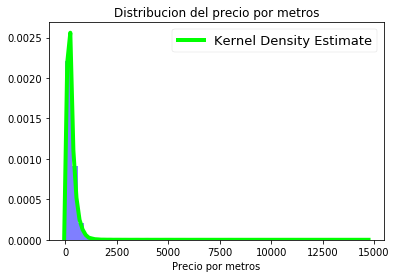

In [28]:
#analiazando distribucion generar de precio por metros
figure = plt.figure()

plt.title('Distribucion del precio por metros', color = 'black')

sns.set_context('talk')
sns.set_context('talk')
sns.distplot(df_filtrado['precio por metros'],axlabel = "Precio por metros",\
            kde_kws={"color": "lime", "lw":4, "label": "Kernel Density Estimate"},\
            hist_kws={"linewidth": 10, "alpha": 0.5, "color": "b"})

In [ ]:
#distribucion de precio y metros totales
sns.jointplot(x=df_filtrado["precio"], y=df_filtrado["metrostotales"], kind = 'kde', s=200, color='m', edgecolor="skyblue", linewidth=2)

# Analizar precio por metros con ciudades

In [ ]:
#analizando top 10 ciudades del pais con mayor precio por metros
df_ciudad = df_filtrado.groupby('ciudad').agg({'precio por metros':'mean'})
df_ciudad_top10 = df_ciudad[['precio por metros']].sort_values('precio por metros', ascending = False)[:10]
df_ciudad_top10
df_ciudad_top10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0, 0, 0.75),title = 'Top10 promedio de precio por metros de ciudad del pais' )

In [ ]:
#analizando bottom 10 ciudades del pais con menor precio por metros
df_ciudad_bottom10 = df_ciudad[['precio por metros']].sort_values('precio por metros', ascending = True)[0:10]
df_ciudad_bottom10
df_ciudad_bottom10.sort_values('precio por metros').plot(kind='bar',figsize=(16,8), color=(0.75, 0.75, 0),title = 'Bottom10 promedio de precio por metros de ciudad del pais' )

In [ ]:
#analizo top 5 provincias con mayor publicacion de ventas
df_filtrado['provincia'].value_counts(normalize = 1)